In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import pandas as pd
import json
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report

task_map = {'Quantity':1,'MeasuredProperty':2,'MeasuredEntity':3,'Qualifier':4, 'Unit':5}

In [2]:
currentdir = os.getcwd() # ~/MeasEval/baselines

datapath = os.path.join(currentdir,'data/output/')

rb_base_path = os.path.join(datapath+'final_roberta-base_bs-8_lr-7e-05_drop-0.03/')
rb_bio_path = os.path.join(datapath+'final_biomed_roberta_base_bs-8_lr-7e-05_drop-0.03/')
rb_cs_path = os.path.join(datapath+'final_cs_roberta_base_bs-8_lr-7e-05_drop-0.03/')

In [3]:
base_test = pd.read_csv(rb_base_path+'test_set_metrics')
bio_test = pd.read_csv(rb_bio_path+'test_set_metrics')
cs_test = pd.read_csv(rb_cs_path+'test_set_metrics')

base_test['model'] = 'Base Roberta'
bio_test['model'] = 'Biomed Roberta'
cs_test['model'] = 'CS Roberta'

test_metrics = pd.concat([base_test, bio_test, cs_test],ignore_index=True).rename(columns={'Unnamed: 0':'epoch'})

test_metrics.loc[0]

epoch                                    0
Quantity_precision                0.698337
Quantity_recall                      0.784
Quantity_f1-score                 0.738693
Quantity_support                       375
MeasuredProperty_precision             0.0
MeasuredProperty_recall                0.0
MeasuredProperty_f1-score              0.0
MeasuredProperty_support               196
MeasuredEntity_precision          0.393939
MeasuredEntity_recall             0.034946
MeasuredEntity_f1-score           0.064198
MeasuredEntity_support                 372
Qualifier_precision                    0.0
Qualifier_recall                       0.0
Qualifier_f1-score                     0.0
Qualifier_support                      174
Unit_precision                    0.755556
Unit_recall                       0.781609
Unit_f1-score                     0.768362
Unit_support                           174
wt_f1                             0.336628
model                         Base Roberta
Name: 0, dt

In [4]:
set(test_metrics['model'].values)

{'Base Roberta', 'Biomed Roberta', 'CS Roberta'}

In [5]:

for task, taskid in task_map.items():
    task_scores = test_metrics[['epoch','model',task+'_f1-score']]
    for model in set(test_metrics['model'].values):
        label = model
        epoch = task_scores[task_scores['model']==model]['epoch'].values
        metric = task_scores[task_scores['model']==model][task+'_f1-score'].values
        
    

In [6]:
task_f1s = [t+'_f1-score' for t in list(task_map.keys())]

task_f1s.append('wt_f1')

print(task_f1s)


['Quantity_f1-score', 'MeasuredProperty_f1-score', 'MeasuredEntity_f1-score', 'Qualifier_f1-score', 'Unit_f1-score', 'wt_f1']


[0, 0, 1, 1, 2, 2] [0, 1, 0, 1, 0, 1]


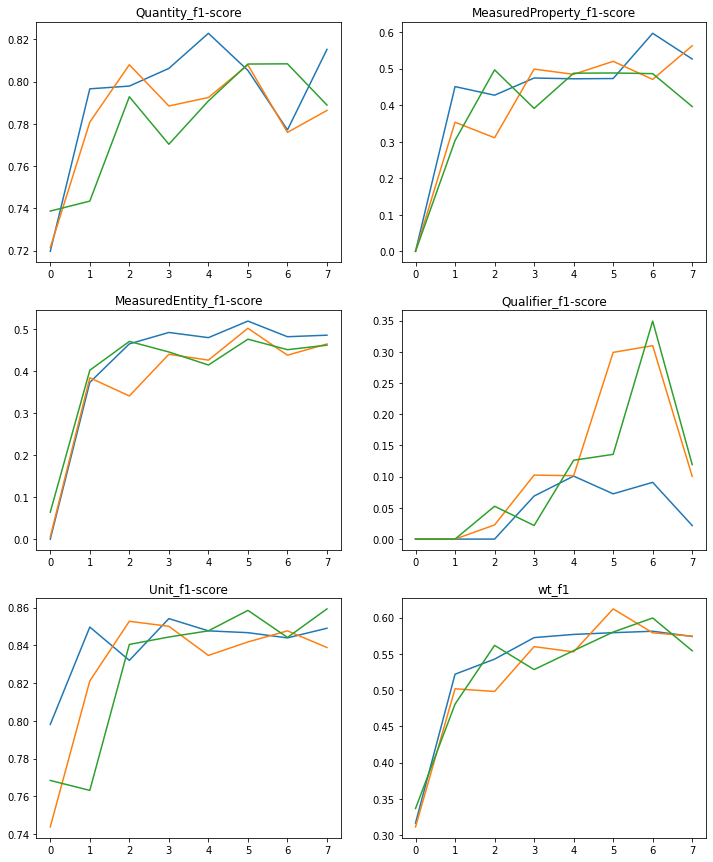

In [7]:
nrows = 3
ncols = 2
fig,ax=plt.subplots(nrows=nrows,ncols=ncols,figsize=(12,15))

task_f1s = [t+'_f1-score' for t in list(task_map.keys())]

task_f1s.append('wt_f1')

r_ = []
c_ = []
for r in range(nrows):
    for c in range(ncols):
        r_.append(r)
        c_.append(c)
print(r_,c_)

for metric_name, r, c in zip(task_f1s, r_, c_):
    task_scores = test_metrics[['epoch','model',metric_name]]
    for model in set(test_metrics['model'].values):
        label = model
        epoch = task_scores[task_scores['model']==model]['epoch'].values
        metric = task_scores[task_scores['model']==model][metric_name].values
        ax[r,c].plot(epoch,metric,label=label)
        ax[r,c].title.set_text(metric_name)





plt.show()

In [8]:
doc_categories = pd.read_csv(currentdir+'/fileCategories.txt',sep='\t',header=None,names=['doc','category'])

doc_categories = dict(zip(doc_categories['doc'],doc_categories['category']))
# doc_categories

In [9]:
def scores_by_category(preds_labs_path):

    with open(preds_labs_path+'/ypred_by_doc.json','r') as f:
        ypred = json.load(f)
    with open(preds_labs_path+'/ytrue_by_doc.json','r') as f:
        ytrue = json.load(f)

    ypred_by_cat = {    
        'Earth Science':[],
        'Biology':[],
        'Chemistry':[],
        'Mathematics':[],
        'Astronomy':[],
        'Materials Science':[],
        'Medicine':[],
        'Engineering':[],
        'Computer Science':[],
        'Agriculture':[]
    }
    ytrue_by_cat = {    
        'Earth Science':[],
        'Biology':[],
        'Chemistry':[],
        'Mathematics':[],
        'Astronomy':[],
        'Materials Science':[],
        'Medicine':[],
        'Engineering':[],
        'Computer Science':[],
        'Agriculture':[]
    }
    for doc in ypred.keys():
        fulldoc = doc.split('-')[0]
        cat = doc_categories[fulldoc]
        ypred_by_cat[cat].extend(ypred[doc])
        ytrue_by_cat[cat].extend(ytrue[doc])
        # print(doc,cat)
        # print(len(ypred_by_cat[cat]))

    f1_by_cat = {}
    for cat in set(doc_categories.values()):
        report = classification_report(
                    ytrue_by_cat[cat],ypred_by_cat[cat],
                    labels=list(task_map.values()),
                    target_names=list(task_map.keys()),
                    output_dict=True,
                    zero_division=0
                )
        f1_by_cat[cat] = report['weighted avg']['f1-score']

    return pd.DataFrame.from_dict(f1_by_cat,orient='index',columns=['Weighted Avg f1'])


rb_base_cat_scores = scores_by_category(rb_base_path)
rb_bio_cat_scores = scores_by_category(rb_bio_path)
rb_cs_cat_scores = scores_by_category(rb_cs_path)

cat_scores = pd.concat([rb_base_cat_scores,rb_bio_cat_scores,rb_cs_cat_scores],axis=1)

cat_scores.columns = ['Roberta base f1','Roberta biomed f1','Roberta cs f1']

cat_scores


,Roberta base f1,Roberta biomed f1,Roberta cs f1
Agriculture,0.722634,0.792302,0.745062
Earth Science,0.592917,0.649578,0.601088
Engineering,0.571923,0.581912,0.602764
Astronomy,0.551687,0.451621,0.509563
Mathematics,1.000000,1.000000,0.901961
Chemistry,0.594037,0.655978,0.646515
Biology,0.757308,0.820781,0.855682
Materials Science,0.606087,0.587186,0.650934
Medicine,0.421024,0.567650,0.511932
Computer Science,0.592593,0.878307,0.777778


<AxesSubplot:>

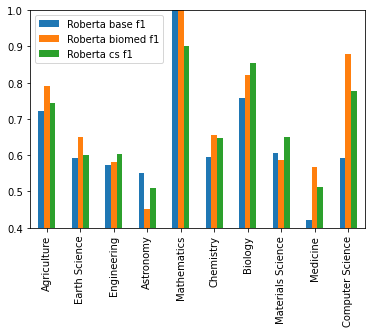

In [10]:
cat_scores.plot.bar(ylim=(.4,1))

In [11]:
cat_scores['cs_%change'] = ((cat_scores['Roberta cs f1'] - cat_scores['Roberta base f1']) / cat_scores['Roberta cs f1']).values

cat_scores['bio_%change'] = ((cat_scores['Roberta biomed f1'] - cat_scores['Roberta base f1']) / cat_scores['Roberta biomed f1']).values

cat_scores

,Roberta base f1,Roberta biomed f1,Roberta cs f1,cs_%change,bio_%change
Agriculture,0.722634,0.792302,0.745062,0.030102,0.087932
Earth Science,0.592917,0.649578,0.601088,0.013594,0.087227
Engineering,0.571923,0.581912,0.602764,0.051165,0.017165
Astronomy,0.551687,0.451621,0.509563,-0.082668,-0.221570
Mathematics,1.000000,1.000000,0.901961,-0.108696,0.000000
Chemistry,0.594037,0.655978,0.646515,0.081170,0.094426
Biology,0.757308,0.820781,0.855682,0.114965,0.077332
Materials Science,0.606087,0.587186,0.650934,0.068896,-0.032189
Medicine,0.421024,0.567650,0.511932,0.177578,0.258303
Computer Science,0.592593,0.878307,0.777778,0.238095,0.325301
